### Задача:
Cоздать прогностическую модель рисков ухудшения здоровья у беременных.

### Описание данных

- `Age`: Age in years when a woman is pregnant.
- `SystolicBP`: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `DiastolicBP`: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
- `BS`: Blood glucose levels is in terms of a molar concentration, mmol/L.
- `HeartRate`: A normal resting heart rate in beats per minute.
- `Risk Level`: Predicted Risk Intensity Level during pregnancy considering the previous attribute.


### План решения задачи:

1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Обучение модели
5. Вывод результатов и анализ модели


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from optuna.integration import OptunaSearchCV
import optuna
from sklearn.neighbors import LocalOutlierFactor
from catboost import CatBoostClassifier
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 1. Загрузка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/My Drive/Colab Notebooks/Maternal Health Risk Data Set.csv'


In [ ]:
df = pd.read_csv(file_path)

In [ ]:
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


### 2. Предобработка данных

Заменяем пробелы в названиях столбцов на нижнее подчёркивание и переводим все символы в нижний регистр для удобства

In [ ]:
def convert_to_snake_case(column_name):
    '''
    Функция проходит по каждому символу в строке column_name с помощью цикла for.
    Для каждого символа проверяется, является ли он заглавной буквой с помощью метода isupper().
    Если символ является заглавной буквой и если он не является первым символом строки (проверка i > 0) и
    предыдущий символ не является заглавной буквой (проверка column_name[i - 1].islower()), то перед текущим символом добавляется символ подчеркивания.
    Это делается для того, чтобы обработать случай, когда в названии столбца встречаются сокращения или аббревиатуры, например, "BP" в "SystolicBP".
    Затем текущая буква преобразуется к нижнему регистру с помощью метода lower() и добавляется к строке snake_case_name.
    Если символ не является заглавной буквой, он просто добавляется к строке snake_case_name.
    В конце функция возвращает строку snake_case_name, представляющую собой название столбца в формате snake_case.
    '''
    snake_case_name = ''
    for i, char in enumerate(column_name):
        if char.isupper():
            if i > 0 and column_name[i - 1].islower():
                snake_case_name += '_'
            snake_case_name += char.lower()
        else:
            snake_case_name += char
    return snake_case_name

Cоздаем новый список с переименованными названиями столбцов и присваиваем новые названия столбцам в наш df

In [ ]:
new_columns = [convert_to_snake_case(col) for col in df.columns]

df.columns = new_columns
df.columns

Index(['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate',
       'risk_level'],
      dtype='object')

Проверяем пропущенные значения

In [ ]:
df.isna().sum()

age             0
systolic_bp     0
diastolic_bp    0
bs              0
body_temp       0
heart_rate      0
risk_level      0
dtype: int64

### 3. Исследовательский анализ данных

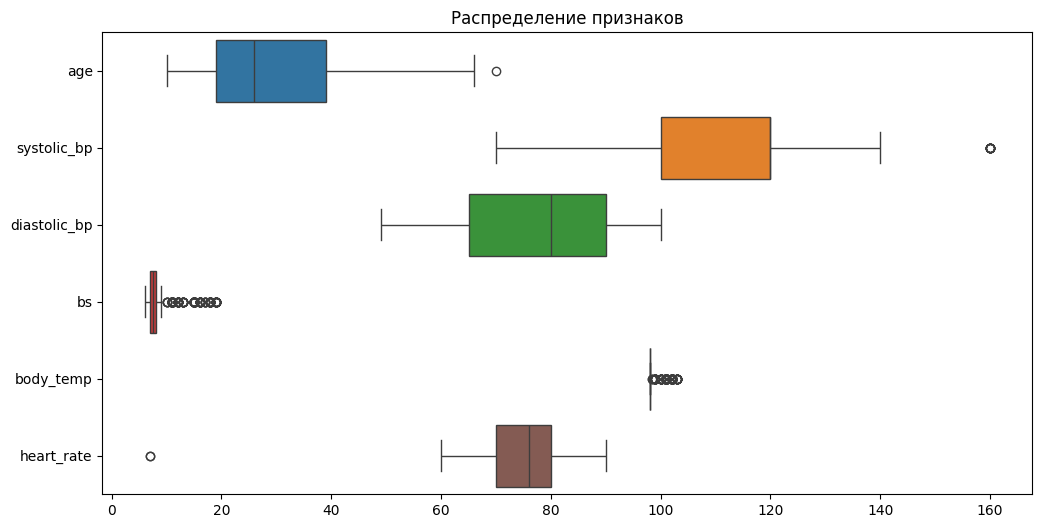

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df,
            orient='h')
plt.title(f'Распределение признаков')
plt.show()

Есть явные выбросы в признаке `hear_rate`. Можно их убрать методом LOF

In [ ]:
lof_model = LocalOutlierFactor()

X_train = df[['heart_rate']]
lof_model.fit(X_train)

outliers = lof_model.fit_predict(X_train)

df = df[outliers != -1]

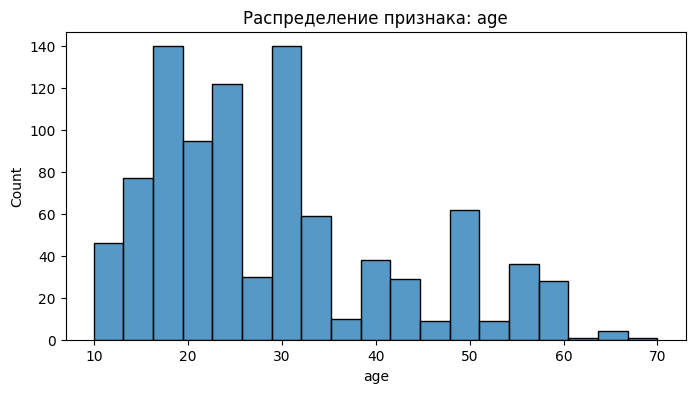

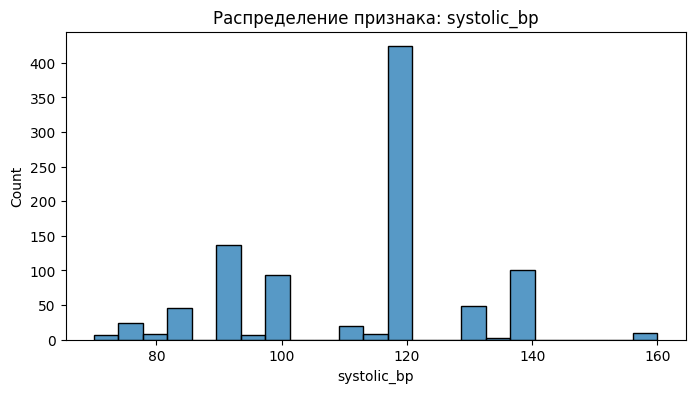

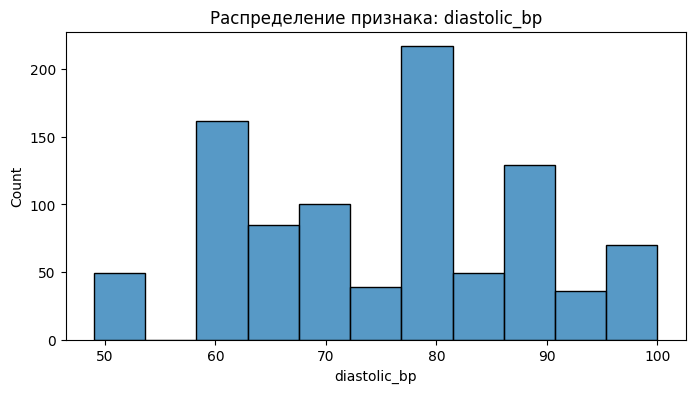

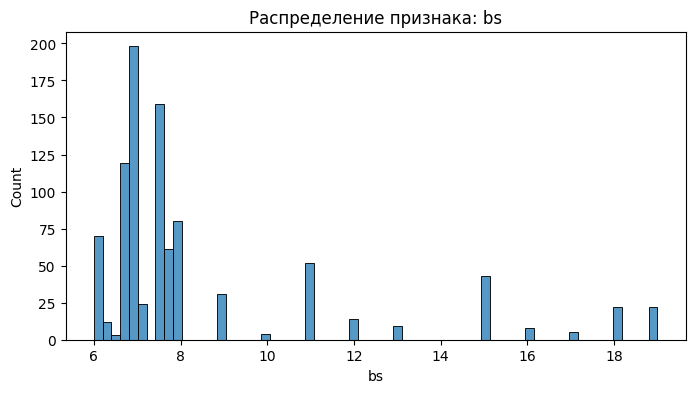

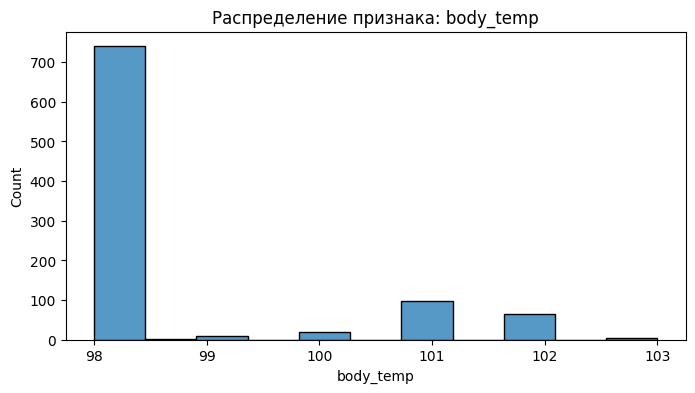

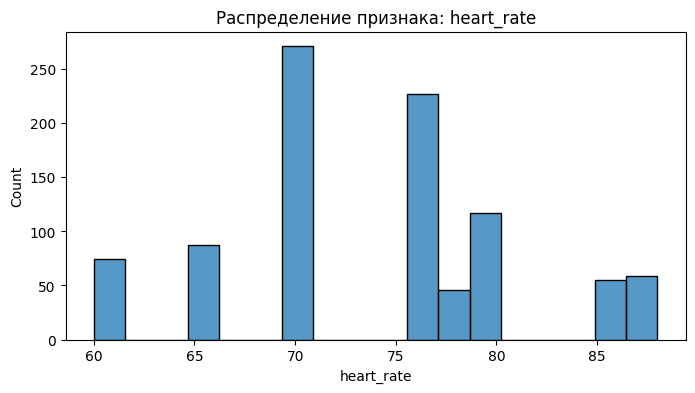

In [ ]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

for column in numeric_columns:
    plt.figure(figsize=(8,4))
    sns.histplot(data=df,
                 x=column)
    plt.title(f'Распределение признака: {column}')
    plt.show()

Распределения данных далеко от нормального. Пытался логорифмировать признаки, но особого эффекта это не дало

Закодируем таргет для обучения

In [ ]:
df['risk_level'].unique()

array(['high risk', 'low risk', 'mid risk'], dtype=object)

In [ ]:
df['risk_level_cat'] = df['risk_level'].map({'high risk': 2, 'mid risk': 1, 'low risk': 0})
df.head()

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,risk_level_cat
0,25,130,80,15.0,98.0,86,high risk,2
1,35,140,90,13.0,98.0,70,high risk,2
2,29,90,70,8.0,100.0,80,high risk,2
3,30,140,85,7.0,98.0,70,high risk,2
4,35,120,60,6.1,98.0,76,low risk,0


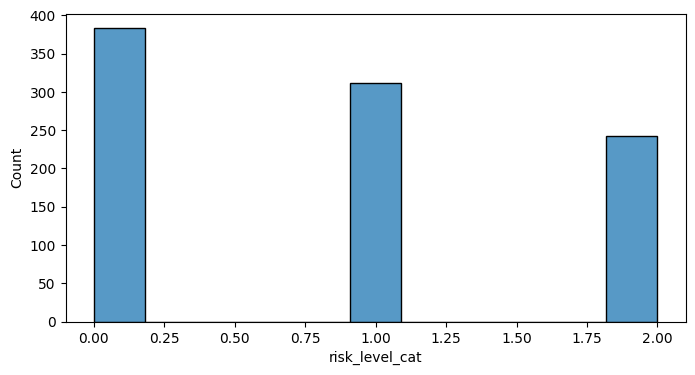

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(data=df,
             x=df['risk_level_cat'])
plt.show()

Есть небольшой дисбаланс классов

Создадим новые признаки

In [ ]:
df.columns

Index(['age', 'systolic_bp', 'diastolic_bp', 'bs', 'body_temp', 'heart_rate',
       'risk_level', 'risk_level_cat'],
      dtype='object')

Отношение верхнего к нижнему артериальному давлению

In [ ]:
df['blood_pressure_ratio'] = df['systolic_bp'] / df['diastolic_bp']

Отношение уровня глюкозы к артериальному давлению

In [ ]:
df['glucose_blood_pressure_ratio'] = df['bs'] / (df['systolic_bp'] + df['diastolic_bp'])

Отношение уровня глюкозы к температуре тела

In [ ]:
df['glucose_body_temp_ratio'] = df['bs'] / df['body_temp']

Отношение верхнего артериального давления к пульсу

In [ ]:
df['systolic_bp_heart_rate_ratio'] = df['systolic_bp'] / df['heart_rate']

Разница между верхним и нижним артериальным давлением

In [ ]:
df['bp_difference'] = df['systolic_bp'] - df['diastolic_bp']

In [ ]:
df

,age,systolic_bp,diastolic_bp,bs,body_temp,heart_rate,risk_level,risk_level_cat,blood_pressure_ratio,glucose_blood_pressure_ratio,glucose_body_temp_ratio,systolic_bp_heart_rate_ratio,bp_difference
0,25,130,80,15.0,98.0,86,high risk,2,1.625000,0.071429,0.153061,1.511628,50
1,35,140,90,13.0,98.0,70,high risk,2,1.555556,0.056522,0.132653,2.000000,50
2,29,90,70,8.0,100.0,80,high risk,2,1.285714,0.050000,0.080000,1.125000,20
3,30,140,85,7.0,98.0,70,high risk,2,1.647059,0.031111,0.071429,2.000000,55
4,35,120,60,6.1,98.0,76,low risk,0,2.000000,0.033889,0.062245,1.578947,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk,2,2.000000,0.083333,0.153061,1.500000,60
1010,55,120,90,18.0,98.0,60,high risk,2,1.333333,0.085714,0.183673,2.000000,30
1011,35,85,60,19.0,98.0,86,high risk,2,1.416667,0.131034,0.193878,0.988372,25
1012,43,120,90,18.0,98.0,70,high risk,2,1.333333,0.085714,0.183673,1.714286,30


### 4. Обучение модели

Используем Catboost

In [ ]:
features = df.drop(['risk_level', 'risk_level_cat'], axis=1)
target = df['risk_level_cat']
random_state = 1234
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.2,
                                                                            random_state=random_state)

param = {
    'learning_rate': optuna.distributions.FloatDistribution(1e-4, 1, log=True),
    'iterations': optuna.distributions.IntDistribution(800, 1200),
    'depth': optuna.distributions.IntDistribution(1, 10),
    'min_data_in_leaf': optuna.distributions.IntDistribution(1, 10),
    'colsample_bylevel': optuna.distributions.FloatDistribution(0.05, 1.0),
}


clf = CatBoostClassifier(auto_class_weights='Balanced',
                         verbose=False)

optuna_search = OptunaSearchCV(clf,
                               param,
                               cv=3,
                               n_trials=50,
                               scoring='recall_weighted',
                               timeout=500,
                               verbose=3,
                               n_jobs=-1)

optuna_search.fit(features_train,
                  target_train)

print("Best Recall on train:", optuna_search.best_score_)
print("Best parameters:", optuna_search.best_params_)

test_predictions = optuna_search.predict(features_test)

recall = recall_score(target_test,
                      test_predictions,
                      average='weighted')
f1 = f1_score(target_test,
              test_predictions,
              average='weighted')

print("Recall on test:", recall)
print("F1 score on test:", f1)
print(classification_report(target_test, test_predictions))

<ipython-input-23-9417f9c6e046>:21: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(clf,
[I 2024-04-22 11:18:39,561] A new study created in memory with name: no-name-e90386b3-570e-4cb3-861b-ecdbc4d0d596
INFO:optuna_integration.sklearn:Searching the best hyperparameters using 748 samples...
[I 2024-04-22 11:18:43,485] Trial 0 finished with value: 0.6858313253012048 and parameters: {'learning_rate': 0.002113223292523986, 'iterations': 1066, 'depth': 1, 'min_data_in_leaf': 4, 'colsample_bylevel': 0.878037168969117}. Best is trial 0 with value: 0.6858313253012048.
[I 2024-04-22 11:19:25,527] Trial 1 finished with value: 0.8061686746987952 and parameters: {'learning_rate': 0.160585238828122, 'iterations': 982, 'depth': 9, 'min_data_in_leaf': 1, 'colsample_bylevel': 0.5036290286687811}. Best is trial 1 with value: 0.8061686746987952.
[I 2024-04-22 11:19:27,983] Trial 3 finished with value: 

Best Recall on train: 0.832904953145917
Best parameters: {'learning_rate': 0.5522044756915883, 'iterations': 1034, 'depth': 8, 'min_data_in_leaf': 6, 'colsample_bylevel': 0.10457187018145014}
Recall on test: 0.8457446808510638
F1 score on test: 0.8460189663001794
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        75
           1       0.79      0.83      0.81        64
           2       0.90      0.90      0.90        49

    accuracy                           0.85       188
   macro avg       0.85      0.85      0.85       188
weighted avg       0.85      0.85      0.85       188



### 5. Вывод результатов и анализ модели

Важноссть каждого признака

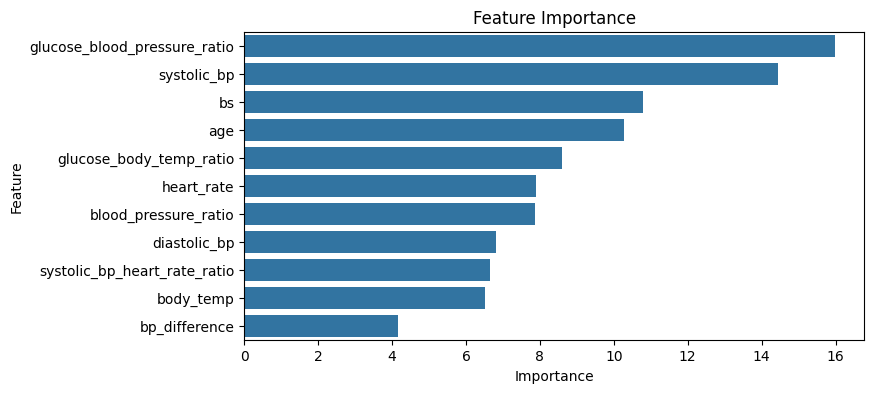

In [ ]:
feature_importance = optuna_search.best_estimator_.feature_importances_
feature_names = features_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names,
                                      'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance',
                                                          ascending=False)

plt.figure(figsize=(8, 4))
sns.barplot(data=feature_importance_df,
            x='Importance',
            y='Feature')
plt.title('Feature Importance')
plt.show()

In [ ]:
print("Recall on test:", recall)
print("F1 score on test:", f1)
print(classification_report(target_test, test_predictions))

Recall on test: 0.8457446808510638
F1 score on test: 0.8460189663001794
              precision    recall  f1-score   support

           0       0.86      0.83      0.84        75
           1       0.79      0.83      0.81        64
           2       0.90      0.90      0.90        49

    accuracy                           0.85       188
   macro avg       0.85      0.85      0.85       188
weighted avg       0.85      0.85      0.85       188



Матрица ошибок на тренировочном и на тестовом наборе данных

In [ ]:
train_conf_matrix = confusion_matrix(target_train, optuna_search.predict(features_train))
test_conf_matrix = confusion_matrix(target_test, test_predictions)

print('Confusion matrix on train:')
print(train_conf_matrix)

print('----------------')

print('Confusion matrix on test:')
print(test_conf_matrix)

Confusion matrix on train:
[[278  25   5]
 [  7 226  14]
 [  1   1 191]]
----------------
Confusion matrix on test:
[[62 12  1]
 [ 7 53  4]
 [ 3  2 44]]


Результат:
- Recall на тестовом наборе данных составляет 0.8457446808510638. Это показывает, что модель корректно идентифицирует примерно 84.5% всех положительных случаев (истинно положительные) из общего числа реальных положительных случаев. Для нас это основная метрика так как для задачи выявления риска беременности важно минимизировать ложноотрицательные результаты, то есть случаи, когда модель не обнаруживает настоящий риск (false negatives).
